In [1]:
from PKRP import  PolyKernelRandomProjection

In [2]:
# Load and scale MNIST data

from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(-1,28*28)/128. - 1
X_test = X_test.reshape(-1,28*28)/128. - 1

Using Theano backend.


### Experiments on classification accuracy

In [3]:
from sklearn.model_selection import  train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.svm import LinearSVC, SVC

In [4]:
# Linear SVM accuracy (91-92%)
# Can be improved a bit by StandardScalling and adjusting C

lsvm = LinearSVC(C=.5).fit(X_train, Y_train)
print lsvm.score(X_test, Y_test) 

0.9154


In [5]:
# PolyKernelRandomProjection + Linear SVM accuracy (97-98%)
# An appropiate C value must be selected for each case. Satandard-Scalling may be used between the projection and the SVM.

pkrp_svm = Pipeline([("kRP", PolyKernelRandomProjection(n_components=2000, p=488, t=10, degree=2)),
                     #("standarize", StandardScaler()),
                     ("SVM", LinearSVC(C=5e-5))
                    ])

pkrp_svm.fit(X_train, Y_train)
print pkrp_svm.score(X_test, Y_test)

0.973


In [4]:
# Poly-kernel SVM accuracy (aprx. 98%)

svm = SVC(C=0.5, kernel="poly", gamma=1., degree=2, coef0=0).fit(  X_train, Y_train)
print svm.score(X_test, Y_test)

0.9784


## Experiments on distance preservation

In [3]:
X_test_small = X_test[0:500]

In [4]:
# Compute the pairwise distance matrix in the kernel feature space for the degree-two homogeneous poly kernel
# K = <x,y>^2
# Distances in the kernel feature space can be computed as Dxy = K(x,x) + K(y,y) - 2 K(x,y)

import numpy as np

Kxx = np.sum(X_test_small**2, axis=1)**2
Kxx = Kxx.reshape((500,1))
Kxy = np.dot(X_test_small, X_test_small.T)**2

D = np.zeros((500,500))
D += Kxx 
D += Kxx.T
D += -2*Kxy

In [9]:
from sklearn.metrics import pairwise_distances

# Compute a Random Projection from the kernel feature space down to R^1000
# and compute the pairwise distance matrix for that representation

krp =  PolyKernelRandomProjection(n_components=500, p=8000, t=20, degree=2, minimize_repetition=False).fit(X_test_small)

X_pkrp = krp.transform(X_test_small)
D_pkrp = pairwise_distances(X_pkrp)**2

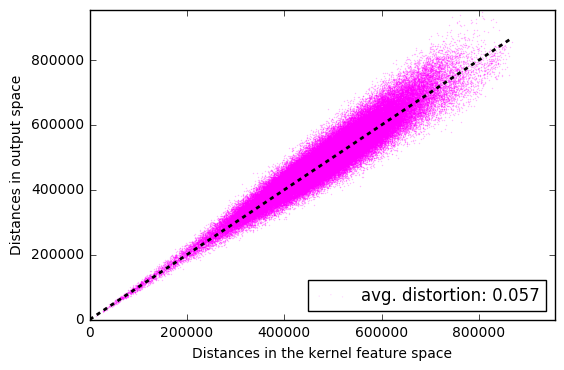

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Plot distances in the kernel feature space against distances in the output representation
# Also compute the average relative distortion

avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
plt.scatter(D.ravel(), D_pkrp.ravel(), s=1, alpha=0.15, c="magenta", linewidths=0)
plt.legend(["avg. distortion: %.3f"%avgdist], loc="lower right")
plt.plot([0,np.max(D)],[0,np.max(D)], c="black", linewidth=2, dashes=[3,3])
plt.xlim([0, np.max(D)*1.1])
plt.ylim([0, np.max(D)*1.1])
plt.xlabel("Distances in the kernel feature space")
plt.ylabel("Distances in output space")

plt.show()

In [ ]:
# Use this to create the GIF in the repo

#avgdistList = []
#ncomLis = []
#
#
#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 4
#
#plt.subplots_adjust(wspace=2)
#plt.figure()
#
#for i in range(5, 500):
#    print i
#    temp = []
#    for j in range(1,4):
#
#        X_pkrp = PolyKernelRandomProjection(n_components=i, p=5000, t=20, degree=2).fit_transform(X_test_small)
#        D_pkrp = pairwise_distances(X_pkrp)**2
#
#
#        plt.subplots_adjust(wspace=2)
#        ax1 = plt.subplot(1,2,1)
#        
#        ax1.set_title("n_components = %d"%i)
#        avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
#        temp.append(avgdist)
#        ax1.scatter(D.ravel(), D_pkrp.ravel(), s=1, alpha=0.15, c="magenta", linewidths=0)
#        ax1.legend(["avg. distortion: %.3f"%avgdist], loc="lower right", markerscale=0,handletextpad=-2.0)
#        ax1.plot([0,np.max(D)],[0,np.max(D)], c="black", linewidth=2, dashes=[3,3])
#        ax1.set_xlim([0, np.max(D)*1.1])
#        ax1.set_ylim([0, np.max(D)*1.1])
#        ax1.set_xlabel("Pairwise distances in the kernel feature space")
#        ax1.set_ylabel("Pairwise distances in output space")
#        
#        ax2 = plt.subplot(1,2,2)
#       
#    
#        #avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
#        #ax2.legend(["avg. distortion: %.2f"%avgdist], loc="lower right")
#        ax2.plot(ncomLis, avgdistList, c="red", linewidth=2)
#        ax2.set_xlim([4, 250])
#        ax2.set_ylim([0, .55])
#        ax2.set_xlabel("n_components")
#        ax2.set_ylabel("Avg. distortion")
#        
#        plt.tight_layout()
#
#        #plt.show()
#        plt.savefig("bfig_%04d_%02d.png"%(i,j))
#        plt.clf()
#    
#    ncomLis.append(i)
#    avgdistList.append(np.mean(temp))